## Transcriptome annotation on AWS

### AWS

This notebook execute our workflow using AWS. We explore different [machine types]( https://aws.amazon.com/ec2/instance-types/), first (M5D) and second (M5DN) generation, and three number of CPUs for each machine type: 16, 32, and 64. We will call `configuration` to the combination of `MACHINE_TYPE/CPU`

The input data, transcriptome in FASTA file, is partitioned in the [01 - Data Partitioning.ipynb]( 01%20-%20Data%20Partitioning.ipynb). 20 FASTA files are created for each query size and are uploaded to a S3 storage bucket with prefixes: `nopal-2000-` for input data and `nopal-results-2000-` for the results files (2000 is for the query size processed and will be 2000, 6000 and 10000).

This notebook will create an organizational structure for storing the pipeline and logs files. It includes directories following the convention: `QUERY_SIZE/MACHINE_TYPE/CPU`. See next directory tree for more information:

```bash
$ tree -dt -L 3 -I "n1|n2" ./results/PRJNA320545/
./results/PRJNA320545/
├── 10000
│   ├── m5d
│   │   ├── 64
│   │   ├── 32
│   │   └── 16
│   ├── m5dn
│   │   ├── 64
│   │   ├── 32
│   │   └── 16
│   └── fasta
├── 6000
│   ├── m5d
│   │   ├── 64
│   │   ├── 32
│   │   └── 16
│   ├── m5dn
│   │   ├── 64
│   │   ├── 32
│   │   └── 16
│   └── fasta
└── 2000
    ├── m5d
    │   ├── 64
    │   ├── 32
    │   └── 16
    ├── m5dn
    │   ├── 64
    │   ├── 32
    │   └── 16
    └── fasta

30 directories
```

After completion, each configuration, `QUERY_SIZE/MACHINE_TYPE/CPU`, will include 20 folders with the query name plus the machine type used. Inside each folder you will find a file **pipeline.log** with the runs logs. 

```bash
└── 2000
    ├── m5d
        ├── 64
            ├── 2000_20_m5d.16xlarge
            ├── 2000_19_m5d.16xlarge
            ├── 2000_18_m5d.16xlarge
            ├── 2000_17_m5d.16xlarge
            ├── 2000_16_m5d.16xlarge
            ├── 2000_15_m5d.16xlarge
            ├── 2000_14_m5d.16xlarge
            ├── 2000_13_m5d.16xlarge
            ├── 2000_12_m5d.16xlarge
            ├── 2000_11_m5d.16xlarge
            ├── 2000_10_m5d.16xlarge
            ├── 2000_9_m5d.16xlarge
            ├── 2000_8_m5d.16xlarge
            ├── 2000_7_m5d.16xlarge
            ├── 2000_6_m5d.16xlarge
            ├── 2000_5_m5d.16xlarge
            ├── 2000_4_m5d.16xlarge
            ├── 2000_3_m5d.16xlarge
            ├── 2000_2_m5d.16xlarge
            └── 2000_1_m5d.16xlarge
```

### AWS Configuration

### AWS Access Key

This notebook assumes that you created a AWS access key as described [here](https://docs.aws.amazon.com/IAM/latest/UserGuide/id_credentials_access-keys.html#Using_CreateAccessKey)

To configure the AWS-cli execute **aws configure**

```bash
$ aws configure
AWS Access Key ID [None]: ................W7MTD
AWS Secret Access Key [None]: ....................4dypPikIFg
Default region name [None]: us-east1
Default output format [None]: json
$
```

### Configuration created in this Notebook 

AWS require a full configuration of the instances to run our pipeline. First, an Internet gateway is created. Then, a complete Amazon Virtual Private Cloud (VPC) is created including ACL, routes and subnets.

Finally, the instances are configured at runtime using the **user-data** option creating a file from the template [user-data-ecs.txt](../config/aws/user-data-ecs.txt). This template downloads the [pipeline script](https://cbb-research-dl-blastdb.s3.amazonaws.com/aws-pipeline.sh) to the virtual machine.

The final script of one of the samples is:

```bash
#!/bin/bash
yum update -y
amazon-linux-extras disable docker
amazon-linux-extras install -y ecs
echo 'start=2048, type=fd' | sfdisk /dev/nvme1n1
echo 'start=2048, type=fd' | sfdisk /dev/nvme2n1
yes | mdadm -C /dev/md0 -l raid0 -n 2 /dev/nvme1n1 /dev/nvme2n1
mkfs.xfs /dev/md0
mkdir /data
mount -t xfs /dev/md0 /data
chmod 777 /data
usermod -a -G docker ec2-user
systemctl enable --now --no-block ecs.service
curl -o /data/aws-pipeline.sh https://cbb-research-dl-blastdb.s3.amazonaws.com/aws-pipeline.sh
chmod a+x /data/aws-pipeline.sh

cat <<EOF >workload.sh
time ( docker run -v /data:/data gcr.io/cbb-research-dl/transannot /data/aws-pipeline.sh -k .......6V5WV -p ..................nh0GTeW -m m5d.16xlarge -c 64 -i nopal-6000-1c8b7e48-482e-4a7f-a02c-0710949d5fa9 -o nopal-results-6000-1c8b7e48-482e-4a7f-a02c-0710949d5fa9  -s 6000_13 ) > /data/pipeline.log 2>&1
aws configure set aws_access_key_id .......6V5WV
aws configure set aws_secret_access_key ..................nh0GTeW
aws s3 cp /data/pipeline.log s3://nopal-results-6000-1c8b7e48-482e-4a7f-a02c-0710949d5fa9/6000_13_m5d.16xlarge/
shutdown 0
EOF
chmod a+x workload.sh
./workload.sh &
```

In this script, line 18, trigger the docker command to execute the image that contains all dependencies to execute the pipeline.

After completion, the instance will be terminated and all resources released.

### Set AWS tags for resources

We defined two json files for defining Tags for all the AWS resources created by this notebook. This help to control cost and identify resources. Edit these files and chage the tags accordingly to your needs.

 1. [aws-tags-s3.json](/edit/config/aws/aws-tags-s3.json) Tags used by S3
 2. [aws-tags.json](/edit/config/aws/aws-tags.json) Tags used by all other resources


### Loading packages from config/init.py

In [1]:
%run ../config/init.py

### Testing AWS-cli configuration

In [227]:
access_key = !aws configure get aws_access_key_id
secret_access_key = !aws configure get aws_secret_access_key
if access_key and secret_access_key:
    print('Using access_key: ........{}'.format(access_key[0][10:]))
else:
    print('Please, configure AWS-cli before running this notebook')
    print('Open a Terminal and run: aws configure')

Using access_key: ........XVULYDAZGO


### Defining variables

Edit AWS zone and region variable accordingly to your geographical location.

In [228]:
REGION = 'us-east-2'
ZONE = 'us-east-2a'
!aws configure set region {REGION}

### Defining global Tags for identifying resources

Associate AWS Tags with each resource created by this notebook helps to compile total cost used by AWS.
The notebook will use, if exists, a file in the **CONFIG/aws** folder named: **aws-tags.json**

In [229]:
TAGFILE_S3 = None
TAGFILE = None
TAGDIR = None
if os.path.exists(os.path.join(CONFIG, "aws", "aws-tags-s3.json")):
    TAGFILE_S3 = os.path.join(CONFIG, "aws", "aws-tags-s3.json")
if os.path.exists(os.path.join(CONFIG, "aws", "aws-tags.json")):
    TAGFILE = os.path.join(CONFIG, "aws", "aws-tags.json")
    with open(TAGFILE) as fin:
        TAGDICT = json.loads(fin.read())
    PROJECT = None
    for k in TAGDICT['Tags']:
        if k['Key'] == 'Project':
            PROJECT = k['Value']
    if PROJECT:
        print("Using project tag: {}".format(PROJECT))

Using project tag: cbb-research-dl


### AWS machine types

| Instance Size | vCPU | Memory (GiB) | Instance Storage (GiB) | Network Bandwidth (Gbps) | EBS Bandwidth (Mbps) | $/Hour |
|---------|----------|----------|-------------|---------------|---------------|-----------|
| m5d.4xlarge | 16 | 64 | 2 x 300 NVMe SSD | Up to 10 | 4,750 | 0.904 |
| m5d.8xlarge | 32 | 128 | 2 x 600 NVMe SSD | 10 | 6,800 | 1.808 |
| m5d.16xlarge | 64 | 256 | 4 x 600 NVMe SSD | 20 | 13,600 | 3.616 |
| m5dn.4xlarge | 16 | 64 | 2 x 300 NVMe SSD | Up to 25 | 4,750 | 1.088 |
| m5dn.8xlarge | 32 | 128 | 2 x 600 NVMe SSD | 25 | 6,800| 2.176 |
| m5dn.16xlarge | 64 | 256 | 4 x 600 NVMe SSD | 75 | 13,600 | 4.352 |


 

In [248]:
QUERY_SIZES = [2000, 6000, 10000]

MACHINE_TYPES = ['m5d', 'm5dn']
CPUs = [
    {
        'name':'4xlarge',
        'CPUs': 16,
        'memory': 64 * 1000 - 5000
    }, 
    {
        'name':'8xlarge',
        'CPUs': 32,
        'memory': 128 * 1000 - 5000
    }, 
    {
        'name':'16xlarge',
        'CPUs': 64,
        'memory': 256 * 1000 - 5000
    }]

# Prices from 03/04/2020
PRICE = {
    'm5d':{
        16: 0.904,
        32: 1.808,
        64: 3.616
    },
    'm5dn':{
        16: 1.088,
        32: 2.176,
        64: 4.352
    }    
}


In [231]:
result_dir = os.path.join(RESULTS, DATASET)
if not os.path.exists(result_dir):
    os.mkdir(result_dir) 
os.chdir(result_dir)
print('Using as output directory: {}'.format(result_dir))

Using as output directory: /panfs/pan1.be-md.ncbi.nlm.nih.gov/alt_splicing/cloud-transcriptome-annotation/results/PRJNA320545


### Create or retrieve AWS S3 storage bucket

In [232]:
bucket_list = !aws s3 ls | awk '{print $3}'
buckets = {}
for q in QUERY_SIZES:
    prefix = 'nopal-' + str(q) + '-'
    suffix = None
    for l in bucket_list:
        if prefix in l:
            suffix = l.replace('nopal-' + str(q) + '-','')
            break
    if suffix:
        buckets[q] = suffix    

for q in QUERY_SIZES:
    if q not in buckets:
        suffix = str(uuid.uuid4())
        inbucket = 'nopal-' + str(q) + '-' + suffix
        outbucket = 'nopal-results-' + str(q) + '-' + suffix
        buckets[q] = suffix 
        
        !aws s3 mb s3://{inbucket} --region {REGION}          
        !aws s3 mb s3://{outbucket} --region {REGION}
        if TAGFILE_S3:
            !aws s3api put-bucket-tagging --bucket {inbucket} --tagging file://{TAGFILE_S3} 
            !aws s3api put-bucket-tagging --bucket {outbucket} --tagging file://{TAGFILE_S3} 
        !aws s3 cp {q}/fasta/ s3://{inbucket}/ --recursive
        
for q in buckets:
    print('Query size: {0}\n\tin-bucket: nopal-{0}-{1}\n\tout-bucket: nopal-results{0}-{1}'.format(q, buckets[q]))

Query size: 2000
	in-bucket: nopal-2000-29e149a0-b69d-4219-9da8-9e8ea8db7c3b
	out-bucket: nopal-results2000-29e149a0-b69d-4219-9da8-9e8ea8db7c3b
Query size: 6000
	in-bucket: nopal-6000-f48da38b-11a6-49ef-9365-b42e8d725732
	out-bucket: nopal-results6000-f48da38b-11a6-49ef-9365-b42e8d725732
Query size: 10000
	in-bucket: nopal-10000-420c3144-ca75-44c9-9796-fc63712f7b39
	out-bucket: nopal-results10000-420c3144-ca75-44c9-9796-fc63712f7b39


## Creating AWS EC2 components

### Creating an Internet gateway.

https://docs.aws.amazon.com/cli/latest/reference/ec2/create-internet-gateway.html

In [233]:
igw = !aws ec2 describe-internet-gateways --filters Name=tag:Project,Values={PROJECT}
igw = json.loads(''.join(igw))   
if 'InternetGateways' in igw and len(igw['InternetGateways']) > 0:
    igw = igw['InternetGateways'][0]
    print('Using Internet Gateway: {}'.format(igw['InternetGatewayId']))
else:
    igw = !aws ec2 create-internet-gateway
    igw = json.loads(''.join(igw))
    if 'InternetGateway' in igw and 'InternetGatewayId' in igw['InternetGateway']:
        igw = igw['InternetGateway']
        print('Created Internet Gateway: {}'.format(igw['InternetGatewayId']))
        if TAGFILE:
            igw_id = igw['InternetGatewayId']
            !aws ec2 create-tags --resources {igw_id} --cli-input-json file://{TAGFILE}

Created Internet Gateway: igw-0da68ab89379ed7a9


### Creating the Amazon Virtual Private Cloud  (VPC) and all its componets

* VPC: https://docs.aws.amazon.com/cli/latest/reference/ec2/create-vpc.html
* ACL: https://docs.aws.amazon.com/cli/latest/reference/ec2/create-network-acl.html
* Route Table: https://docs.aws.amazon.com/cli/latest/reference/ec2/create-route-table.html
* Subnet: https://docs.aws.amazon.com/cli/latest/reference/ec2/create-subnet.html

In [234]:
vpc = !aws ec2 describe-vpcs --filters Name=tag:Project,Values={PROJECT}
vpc = json.loads(''.join(vpc))
if 'Vpcs' in vpc and len(vpc['Vpcs']) > 0:
    vpc = vpc['Vpcs'][0]
    vpc_id = vpc['VpcId']
    print('Using VPC: {}'.format(vpc['VpcId']))
    subnet = !aws ec2 describe-subnets --filters "Name=vpc-id,Values={vpc_id}"
    subnet = json.loads(''.join(subnet))
    if 'Subnets' in subnet:
        subnet = subnet['Subnets'][0]   
        subnet_id = subnet['SubnetId']

        print('Subnet {} attached to VPC {}'.format(subnet_id, vpc_id))    
else:
    print('No VPC, creating it ..... ')
    vpc = !aws ec2 create-vpc --cidr-block 10.0.0.0/16 --amazon-provided-ipv6-cidr-block 
    vpc = json.loads(''.join(vpc))
    if 'Vpc' in vpc:
        vpc = vpc['Vpc']
        vpc_id = vpc['VpcId']
        print('Created VPC: {}'.format(vpc_id))
        # adding Tags if file exists
        if TAGFILE:        
            !aws ec2 create-tags --resources {vpc_id} --cli-input-json file://{TAGFILE}

        # Attaching igw
        igw_id = igw['InternetGatewayId']
        print('Attaching IGW {} to the VPC: {}'.format(igw_id, vpc_id))
        !aws ec2 attach-internet-gateway --internet-gateway-id {igw_id} --vpc-id {vpc_id}

        # Retrieving created ACL
        acl = !aws ec2 describe-network-acls --filters Name=vpc-id,Values={vpc_id}
        acl = json.loads(''.join(acl))
        if 'NetworkAcls' in acl and len(acl['NetworkAcls']) == 1:
            acl = acl['NetworkAcls'][0]
            # adding Tags if file exists
            if TAGFILE:                
                acl_id = acl['NetworkAclId']
                print('Tagging ACL {}'.format(acl_id))
                !aws ec2 create-tags --resources {acl_id} --cli-input-json file://{TAGFILE}

        # Retrieving created routes
        route = !aws ec2 describe-route-tables --filters Name=vpc-id,Values={vpc_id}
        route = json.loads(''.join(route))
        if 'RouteTables' in route and len(route['RouteTables']) == 1:
            route = route['RouteTables'][0]
            route_id = route['RouteTableId']
                
            route_igw = !aws ec2 create-route --route-table-id {route_id} --destination-cidr-block 0.0.0.0/0 --gateway-id {igw_id}
            route_igw = json.loads(''.join(route_igw))
            if 'Return' in route_igw and route_igw['Return']:
                print('IGW {} attached to route {}'.format(igw_id, route_id))
            
            # adding Tags if file exists
            if TAGFILE:
                print('Tagging Route {}'.format(route_id))
                !aws ec2 create-tags --resources {route_id} --cli-input-json file://{TAGFILE}

        # Creating Subnets
        subnet = !aws ec2 create-subnet --vpc-id {vpc_id} --cidr-block 10.0.0.0/16 --availability-zone {ZONE}
        subnet = json.loads(''.join(subnet))
        if 'Subnet' in subnet:
            subnet = subnet['Subnet']   
            subnet_id = subnet['SubnetId']
            
            print('Subnet {} attached to VPC {}'.format(subnet_id, vpc_id))
            !aws ec2 modify-subnet-attribute --subnet-id {subnet_id} --map-public-ip-on-launch
            print('Public IPs enable on subnet {}'.format(subnet_id))
            
            # adding Tags if file exists
            if TAGFILE:
                print('Tagging subnet {}'.format(subnet_id))
                !aws ec2 create-tags --resources {subnet_id} --cli-input-json file://{TAGFILE}

No VPC, creating it ..... 
Created VPC: vpc-02c99b5cdee4ff00f
Attaching IGW igw-0da68ab89379ed7a9 to the VPC: vpc-02c99b5cdee4ff00f
Tagging ACL acl-0499bd5f491611101
IGW igw-0da68ab89379ed7a9 attached to route rtb-078f0eaa545716f08
Tagging Route rtb-078f0eaa545716f08
Subnet subnet-032be7db9c0117c19 attached to VPC vpc-02c99b5cdee4ff00f
Public IPs enable on subnet subnet-032be7db9c0117c19
Tagging subnet subnet-032be7db9c0117c19


### Creating AWS Batch 
#### Getting AWSBatchServiceRole information

 * https://docs.aws.amazon.com/cli/latest/reference/iam/list-roles.html

In [235]:
try:
    awsBatchRole = None
    output = !aws iam list-roles
    roles = json.loads(''.join(output))
    if 'Roles' in roles:
        for r in roles['Roles']:
            if 'AWSBatchServiceRole' == r['RoleName']:
                awsBatchRole = r
                print('Using AWSBatchServiceRole: {}'.format(awsBatchRole['Arn']))
                break
    if not awsBatchRole:
        print('Error: AWSBatchServiceRole not available in your account.')
        print('Please, creates the AWSBatchServiceRole before continue as it is described:')
        print('https://docs.aws.amazon.com/batch/latest/userguide/service_IAM_role.html')
except:
    print('Error: {}'.format(output))

Using AWSBatchServiceRole: arn:aws:iam::036922703339:role/AWSBatchServiceRole


### Creation of the AWS Batch System    

#### Creating a security group
 
 * https://docs.aws.amazon.com/cli/latest/reference/ec2/create-security-group.html
 * https://docs.aws.amazon.com/cli/latest/reference/ec2/describe-security-groups.html

In [236]:
sg = !aws ec2 describe-security-groups --filters Name=tag:Project,Values={PROJECT}
sg = json.loads(''.join(sg))
if 'SecurityGroups' in sg and len(sg['SecurityGroups']) >= 1:
    sg = sg['SecurityGroups'][0]
    sg_id = sg['GroupId']
    print('Using sg {}'.format(sg_id))
else:
    sg_name = PROJECT
    sg_descr = 'Security Group for project: ' + PROJECT
    sg = !aws ec2 create-security-group --group-name {sg_name}  --description "{sg_descr}" --vpc-id {vpc_id}
    sg = json.loads(''.join(sg))
    if 'GroupId' in sg:
        sg_id = sg['GroupId']
        print('SG {} created'.format(sg_id))
        
        print('Adding SSH inbound to the sg {}'.format(sg_id))
        !aws ec2 authorize-security-group-ingress --group-id {sg_id} --protocol tcp --port 22 --cidr 0.0.0.0/0
        
        # adding Tags if file exists
        if TAGFILE:
            print('Tagging sg {}'.format(sg_id))
            !aws ec2 create-tags --resources {sg_id} --cli-input-json file://{TAGFILE}

SG sg-0afa1e23579fdc6ff created
Adding SSH inbound to the sg sg-0afa1e23579fdc6ff
Tagging sg sg-0afa1e23579fdc6ff


#### Creating Compuational Environment

 * https://docs.aws.amazon.com/cli/latest/reference/batch/create-compute-environment.html
 * https://docs.aws.amazon.com/cli/latest/reference/batch/describe-compute-environments.html

In [243]:
def create_comp_env_dict(name, CPUs, machine_type, subnet_id, sg_id, batchRoleArn, tags = None, key=None):
    if os.path.exists(os.path.join(CONFIG, "aws", "compute-env-template.json")):
        comp_env_templatefile = os.path.join(CONFIG, "aws", "compute-env-template.json")
        with open(comp_env_templatefile) as fin:
            comp_env = json.loads(fin.read())
            comp_env['computeEnvironmentName'] = name
            comp_env['computeResources']['imageId'] = 'ami-04a8365583a3d92af'
            comp_env['computeResources']['maxvCpus'] = CPUs * 40
            comp_env['computeResources']['instanceTypes'].append(machine_type)
            comp_env['computeResources']['subnets'].append(subnet_id)
            comp_env['computeResources']['securityGroupIds'].append(sg_id)
            if key:
                comp_env['computeResources']['ec2KeyPair'] = key
            if tags:
                ts = {}
                for t in tags:
                    ts[t['Key']] = t['Value']
                comp_env['computeResources']['tags']  = ts
            comp_env['serviceRole'] = batchRoleArn
            with open(os.path.join(CONFIG, "aws", 'compute-env-{}.json'.format(name)), 'w') as fout:
                fout.write(json.dumps(comp_env, indent=4))

In [244]:
for m in MACHINE_TYPES:  
    for c in CPUs:
        instance_type = '{}.{}'.format(m,c['name'])
        comp_env_name = '{}_{}_managed2'.format(m,c['name'])
        comp_env = None
        try:
            output = !aws batch describe-compute-environments --compute-environments {comp_env_name}
            comp_env = json.loads(''.join(output))
            if 'computeEnvironments' in comp_env and len(comp_env['computeEnvironments']) == 1:
                comp_env = comp_env['computeEnvironments'][0]
                print('Using Computational env: {}'.format(comp_env['computeEnvironmentName']))
            else:
                comp_env = None
        except:
            print('Error: {}'.format(output))
        if not comp_env:
            try:
                print('Computational env: {} does not exist. Creating it ...'.format(comp_env_name))
                create_comp_env_dict(comp_env_name, c['CPUs'], instance_type, subnet_id, sg_id, awsBatchRole['Arn'], TAGDICT['Tags'], 'aws-nopal')
                comp_env_json = os.path.join(CONFIG, "aws", 'compute-env-{}.json'.format(comp_env_name))            
                output = !aws batch create-compute-environment --cli-input-json file://{comp_env_json}
                comp_env = json.loads(''.join(output))
                print('Computational env: {} created'.format(comp_env['computeEnvironmentName']))                             
            except:
                print('Error: {}'.format(output))

Computational env: m5d_16xlarge_managed2 does not exist. Creating it ...
Computational env: m5d_16xlarge_managed2 created


#### Creating Job queue

 * https://docs.aws.amazon.com/cli/latest/reference/batch/create-job-queue.html
 * https://docs.aws.amazon.com/cli/latest/reference/batch/describe-job-queues.html

In [239]:
for m in MACHINE_TYPES:  
    for c in CPUs:
        queue_name = '{}_{}_queue'.format(m,c['name'])
        comp_env_name = '{}_{}_managed'.format(m,c['name'])
        queue = None
        try:
            output = !aws batch describe-job-queues --job-queues {queue_name}
            queue = json.loads(''.join(output))
            if 'jobQueues' in queue and len(queue['jobQueues']) == 1:
                queue = queue['jobQueues'][0]
                print('Using queue: {}'.format(queue['jobQueueName']))
            else:
                queue = None

        except:
            print('Error: {}'.format(output))
        if not queue:
            try:
                print('Queue: {} does not exist. Creating it ...'.format(queue_name))
                queue_template_json = os.path.join(CONFIG, "aws", 'queue-template.json')  
                queue_json = os.path.join(CONFIG, "aws", 'queue-{}.json'.format(queue_name))   
                with open(queue_template_json) as fin:
                    with open(queue_json, "w") as fout:
                        queue = json.load(fin)
                        queue['jobQueueName'] = queue_name
                        queue['computeEnvironmentOrder'][0]['computeEnvironment'] = comp_env_name
                        fout.write(json.dumps(queue, indent=4))
                output = !aws batch create-job-queue --cli-input-json file://{queue_json}
                queue = json.loads(''.join(output))
                print('Queue: {} created'.format(queue['jobQueueName']))                             
            except:
                print('Error: {}'.format(output))

Queue: m5d_16xlarge_queue does not exist. Creating it ...
Queue: m5d_16xlarge_queue created


### Registering jobs

 * https://docs.aws.amazon.com/cli/latest/reference/batch/register-job-definition.html
 * https://docs.aws.amazon.com/cli/latest/reference/batch/describe-job-definitions.html

In [240]:
for m in MACHINE_TYPES: 
    for c in CPUs:
        job_def_name = '{}_{}'.format(m,c['name'])
        try:
            output = !aws batch describe-job-definitions --job-definition-name {job_def_name}
            job = json.loads(''.join(output))
            if 'jobDefinitions' in job and len(job['jobDefinitions']) == 1:
                job = job['jobDefinitions'][0]
                print('Using job definition: {}'.format(job['jobDefinitionName']))
            else:
                job = None

        except:
            print('Error: {}'.format(output))
        if not job:       
            try:
                print('Job: {} does not exist. Creating it ...'.format(job_def_name))
                job_template_json = os.path.join(CONFIG, "aws", 'job-definition-template.json')  
                jon_json = os.path.join(CONFIG, "aws", 'job-definition-{}.json'.format(job_def_name))   
                with open(job_template_json) as fin:
                    with open(jon_json, "w") as fout:
                        job = json.load(fin)
                        job['jobDefinitionName'] = job_def_name
                        job['containerProperties']['vcpus'] = c['CPUs']
                        job['containerProperties']['memory'] = c['memory']
                        job['containerProperties']['environment'].append({'name': 'CPUs' , 'value': str(c['CPUs'])})
                        job['containerProperties']['environment'].append({'name': 'MACHINE_TYPE' , 'value': job_name})
                        fout.write(json.dumps(job, indent=4))
                output = !aws batch register-job-definition --cli-input-json file://{jon_json}
                job = json.loads(''.join(output))
                print('Job: {} created'.format(job['jobDefinitionName']))   
            except:
                print('Error: {}'.format(output))

Job: m5d_16xlarge does not exist. Creating it ...
Job: m5d_16xlarge created


### Submitting the jobs to the AWS Batch

 * https://docs.aws.amazon.com/cli/latest/reference/batch/submit-job.html
 
Once jobs are submitted you can view the queues in the AWS console:

 * https://console.aws.amazon.com/batch/
 
The next cell  


In [288]:
bar_length = 20
job_ids = {}

# Check if there are errors in the log events 
def aws_log_times(events):
    for ev in events:
        if ev['message'].startswith('Error'):
            return True
    return False

for q in QUERY_SIZES:
    job_ids[q] = {}
    q_dir = os.path.join(result_dir, str(q))
    for m in MACHINE_TYPES:
        job_ids[q][m] = {}
        for c in CPUs:
            job_ids[q][m][c['CPUs']] = {}
            instace_dir = os.path.join(q_dir, m, str(c['CPUs']))
            if not os.path.exists(instace_dir):
                os.makedirs(instace_dir)
            os.chdir(instace_dir)
            files = [ f for ds, dr, files in os.walk('./') for f in files if f.endswith('_job.json.gz') ]
            for f in files:
                job_id = f.replace('_job.json.gz','')
                with gzip.GzipFile('{}_job.json.gz'.format(job_id), 'r') as fin:  
                    job = json.loads(fin.read().decode('utf-8'))
                    if 'SUCCEEDED' == job['jobs'][0]['status']:                        
                        with gzip.GzipFile('{}_log.json.gz'.format(job_id), 'r') as fin1:  
                            log = json.loads(fin1.read().decode('utf-8'))
                            if not aws_log_times(log['events']):
                                job_name = job['jobs'][0]['jobName']
                                job_ids[q][m][c['CPUs']][job_name] = {}
                                job_ids[q][m][c['CPUs']][job_name]['jobId'] = job_id
                                job_ids[q][m][c['CPUs']][job_name]['job'] = job
                                job_ids[q][m][c['CPUs']][job_name]['log'] = log
                            
    os.chdir(q_dir)

In [290]:
try:
    for m in MACHINE_TYPES: 
        for c in CPUs:
            job_def_name = '{}_{}'.format(m,c['name'])
            for q in QUERY_SIZES: 
                inbucket = 'nopal-' + str(q) + '-' + buckets[q]
                outbucket = 'nopal-results-' + str(q) + '-' + buckets[q]
                for i in range(1,21):
                    sample = '{}_{}'.format(q, i)
                    job_name = '{}_{}'.format(sample, job_def_name) 
                    progress = i * 100/20
                    text = "{0:20} [{1}] {2:.1f}%".format(job_name, "#" * i + "-" * (bar_length - i), progress)
                    print(text, end='\r')                    
                    if job_name not in job_ids[q][m][c['CPUs']]:                
                        cmd = 'aws batch submit-job --job-name {} '.format(job_name)
                        cmd += '--job-queue {}_queue '.format(job_def_name)
                        cmd += '--job-definition {} '.format(job_def_name)
                        cmd += '--container-overrides \'environment=['
                        cmd += '{name=AWS_ACCESS_KEY_ID,value=' + access_key[0] + '},'
                        cmd += '{name=AWS_SECRET_ACCESS_KEY,value=' + secret_access_key[0] + '},'
                        cmd += '{name=SAMPLE,value=' + sample + '},'
                        cmd += '{name=INBUCKET,value=' + inbucket + '},'
                        cmd += '{name=OUTBUCKET,value=' + outbucket + '}]\''

                        output = !{cmd}
                        job_id = json.loads(''.join(output))
                        job_ids[q][m][c['CPUs']][job_name] = {}
                        job_ids[q][m][c['CPUs']][job_name]['jobId'] = job_id['jobId']
                print()
except:
    print('Error: {}'.format(output))                        

2000_20_m5d_4xlarge  [####################] 100.0%
6000_20_m5d_4xlarge  [####################] 100.0%
10000_20_m5d_4xlarge [####################] 100.0%
2000_20_m5d_8xlarge  [####################] 100.0%
6000_20_m5d_8xlarge  [####################] 100.0%
10000_20_m5d_8xlarge [####################] 100.0%
2000_20_m5d_16xlarge [####################] 100.0%
6000_20_m5d_16xlarge [####################] 100.0%
10000_20_m5d_16xlarge [####################] 100.0%
2000_20_m5dn_4xlarge [####################] 100.0%
6000_20_m5dn_4xlarge [####################] 100.0%
10000_20_m5dn_4xlarge [####################] 100.0%
2000_20_m5dn_8xlarge [####################] 100.0%
6000_20_m5dn_8xlarge [####################] 100.0%
10000_20_m5dn_8xlarge [####################] 100.0%
2000_20_m5dn_16xlarge [####################] 100.0%
6000_20_m5dn_16xlarge [####################] 100.0%
10000_20_m5dn_16xlarge [####################] 100.0%


### Retrieving Job description and logs

 * https://docs.aws.amazon.com/cli/latest/reference/batch/describe-jobs.html
 * https://docs.aws.amazon.com/cli/latest/reference/logs/get-log-events.html

In [321]:
total = 0
done = 0
for q in QUERY_SIZES:
    q_dir = os.path.join(result_dir, str(q))
    for m in MACHINE_TYPES:        
        for c in CPUs:    
            instace_dir = os.path.join(q_dir, m, str(c['CPUs']))
            if not os.path.exists(instace_dir):
                os.makedirs(instace_dir)
            os.chdir(instace_dir)
            job_def_name = '{}_{}'.format(m,c['name'])
            completed = 0
            failed = 0
            for i in range(1,21):  
                total += 1
                sample = '{}_{}'.format(q, i)
                job_name = '{}_{}'.format(sample, job_def_name) 
                if job_name in job_ids[q][m][c['CPUs']]:
                    job_id = job_ids[q][m][c['CPUs']][job_name]['jobId']
                    if os.path.exists('{}_job.json.gz'.format(job_id)):                        
                        with gzip.GzipFile('{}_job.json.gz'.format(job_id), 'r') as fin:  
                            job = json.loads(fin.read().decode('utf-8'))
                            with gzip.GzipFile('{}_log.json.gz'.format(job_id), 'r') as fin:  
                                log = json.loads(fin.read().decode('utf-8'))
                                if aws_log_times(log['events']):
                                    completed += 1
                                    done += 1
                                    job_ids[q][m][c['CPUs']][job_name]['job'] = job
                                    job_ids[q][m][c['CPUs']][job_name]['log'] = log
                    else:
                        output = !aws batch describe-jobs --jobs {job_id}
                        l = json.loads(''.join(output))
                        if 'SUCCEEDED' == l['jobs'][0]['status']:
                            logStreamName = l['jobs'][0]['container']['logStreamName']
                            output = !aws logs get-log-events --log-group-name /aws/batch/job --log-stream-name {logStreamName}
                            log = json.loads(''.join(output))
                            if aws_log_times(log['events']):
                                completed += 1
                                done += 1
                                job_ids[q][m][c['CPUs']][job_name]['job'] = l
                                with gzip.GzipFile('{}_job.json.gz'.format(job_id), 'w') as fout:
                                    fout.write(json.dumps(l, indent=2).encode('utf-8'))
                                job_ids[q][m][c['CPUs']][job_name]['log'] = log
                                with gzip.GzipFile('{}_log.json.gz'.format(job_id), 'w') as fout:
                                    fout.write(json.dumps(job_ids[q][m][c['CPUs']][job_name]['log'], indent=2).encode('utf-8'))
                            else:
                                if os.path.exists('{}_job.json.gz'.format(job_id)):
                                    os.remove('{}_job.json.gz'.format(job_id))
                                if os.path.exists('{}_log.json.gz'.format(job_id)):
                                    os.remove('{}_log.json.gz'.format(job_id))

                        elif 'FAILED' == l['jobs'][0]['status']:
                            failed += 1
                            del job_ids[q][m][c['CPUs']][job_name]
                        else:
                            if os.path.exists('{}_job.json.gz'.format(job_id)):
                                os.remove('{}_job.json.gz'.format(job_id))
                            if os.path.exists('{}_log.json.gz'.format(job_id)):
                                os.remove('{}_log.json.gz'.format(job_id))
                progress = i * 100/20
                text = "{0:13s} [{1}] {2:.1f}%\tQuery: {3} Completed {4} Failed {5}".format(job_def_name, "#" * i + "-" * (bar_length - i), progress, q, completed, failed)
                print(text, end='\r')
            print()
print('Total jobs {}/{}'.format(done, total))

m5d_4xlarge   [####################] 100.0%	Query: 2000 Completed 20 Failed 0
m5d_8xlarge   [####################] 100.0%	Query: 2000 Completed 20 Failed 0
m5d_16xlarge  [####################] 100.0%	Query: 2000 Completed 20 Failed 0
m5dn_4xlarge  [####################] 100.0%	Query: 2000 Completed 20 Failed 0
m5dn_8xlarge  [####################] 100.0%	Query: 2000 Completed 20 Failed 0
m5dn_16xlarge [####################] 100.0%	Query: 2000 Completed 20 Failed 0
m5d_4xlarge   [####################] 100.0%	Query: 6000 Completed 20 Failed 0
m5d_8xlarge   [####################] 100.0%	Query: 6000 Completed 20 Failed 0
m5d_16xlarge  [####################] 100.0%	Query: 6000 Completed 20 Failed 0
m5dn_4xlarge  [####################] 100.0%	Query: 6000 Completed 20 Failed 0
m5dn_8xlarge  [####################] 100.0%	Query: 6000 Completed 20 Failed 0
m5dn_16xlarge [####################] 100.0%	Query: 6000 Completed 20 Failed 0
m5d_4xlarge   [####################] 100.0%	Query: 10000 Complet

### Processing the results

Run this cell after all jobs are terminated.

In [322]:
def aws_log_times(events):
    blast = 0
    cwl = 0
    for ev in events:
        if ev['message'] == 'Copying BlastDB':
            s = ev['timestamp']
        if ev['message'] == 'Copying sample fasta':
            blast = (ev['timestamp'] - s)/(1000*60)
        if ev['message'] == 'Running CWL workflow':
            s = ev['timestamp']
        if ev['message'] == 'Copying results to the S3':
            cwl = (ev['timestamp'] - s)/(1000*60)
    return blast, cwl

In [323]:
for q in QUERY_SIZES:
    boxdata_total = []
    boxdata_blast = []
    boxdata_creation = []
    q_dir = os.path.join(result_dir, str(q))
    for m in MACHINE_TYPES:        
        for c in CPUs:   
            data = []
            job_def_name = '{}_{}'.format(m,c['name'])
            platform = 'AWS\n{}\n{}'.format(m.upper(), c['CPUs'])
            for i in range(1,21):  
                progress = i * 100/20
                text = "{0:13s} [{1}] {2:.1f}%\tQuery: {3}".format(job_def_name, "#" * i + "-" * (bar_length - i), progress, q)
                print(text, end='\r')
                sample = '{}_{}'.format(q, i)
                job_name = '{}_{}'.format(sample, job_def_name) 
                if job_name in job_ids[q][m][c['CPUs']]:
                    if 'job' in job_ids[q][m][c['CPUs']][job_name]:
                        s = job_ids[q][m][c['CPUs']][job_name]['job']['jobs'][0]['startedAt']
                        e = job_ids[q][m][c['CPUs']][job_name]['job']['jobs'][0]['stoppedAt']                        
                        total = (e-s)/(1000*60)
                        db, cwl = aws_log_times(job_ids[q][m][c['CPUs']][job_name]['log']['events'])
                        data.append([sample, total, db, cwl])
                        
                        boxdata_total.append([total, platform])
                        boxdata_blast.append([db, platform])
                        boxdata_creation.append([total - (cwl + db), platform])
            job_ids[q][m][c['CPUs']]['aws'] = pandas.DataFrame(data, columns=['id', 'AWS', 'BlastDB', 'CWL'])
            print()
    os.chdir(q_dir)
    job_ids[q]['total'] = pandas.DataFrame(boxdata_total, columns=['Time', 'Platform'])
    job_ids[q]['total'].to_csv('aws_total.tsv', sep='\t', index=None)
    job_ids[q]['blast'] = pandas.DataFrame(boxdata_blast, columns=['Time', 'Platform'])
    job_ids[q]['blast'].to_csv('aws_blast.tsv', sep='\t', index=None)
    job_ids[q]['creation'] = pandas.DataFrame(boxdata_creation, columns=['Time', 'Platform'])
    job_ids[q]['creation'].to_csv('aws_creation.tsv', sep='\t', index=None)
             

m5d_4xlarge   [####################] 100.0%	Query: 2000
m5d_8xlarge   [####################] 100.0%	Query: 2000
m5d_16xlarge  [####################] 100.0%	Query: 2000
m5dn_4xlarge  [####################] 100.0%	Query: 2000
m5dn_8xlarge  [####################] 100.0%	Query: 2000
m5dn_16xlarge [####################] 100.0%	Query: 2000
m5d_4xlarge   [####################] 100.0%	Query: 6000
m5d_8xlarge   [####################] 100.0%	Query: 6000
m5d_16xlarge  [####################] 100.0%	Query: 6000
m5dn_4xlarge  [####################] 100.0%	Query: 6000
m5dn_8xlarge  [####################] 100.0%	Query: 6000
m5dn_16xlarge [####################] 100.0%	Query: 6000
m5d_4xlarge   [####################] 100.0%	Query: 10000
m5d_8xlarge   [####################] 100.0%	Query: 10000
m5d_16xlarge  [####################] 100.0%	Query: 10000
m5dn_4xlarge  [####################] 100.0%	Query: 10000
m5dn_8xlarge  [####################] 100.0%	Query: 10000
m5dn_16xlarge [####################] 100.0%

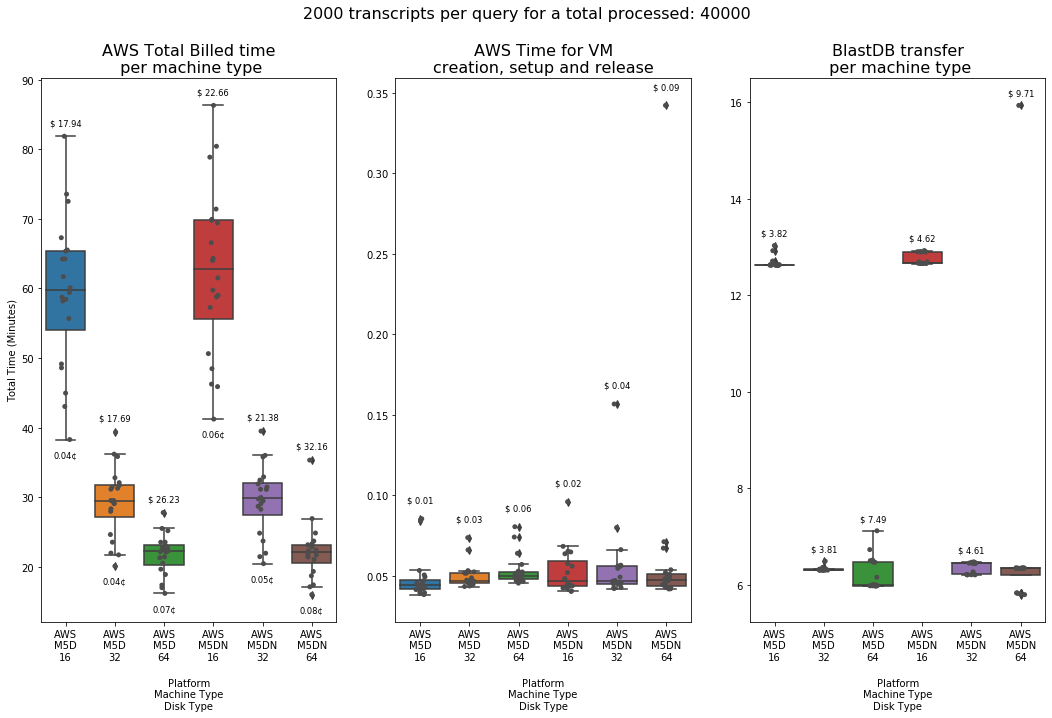

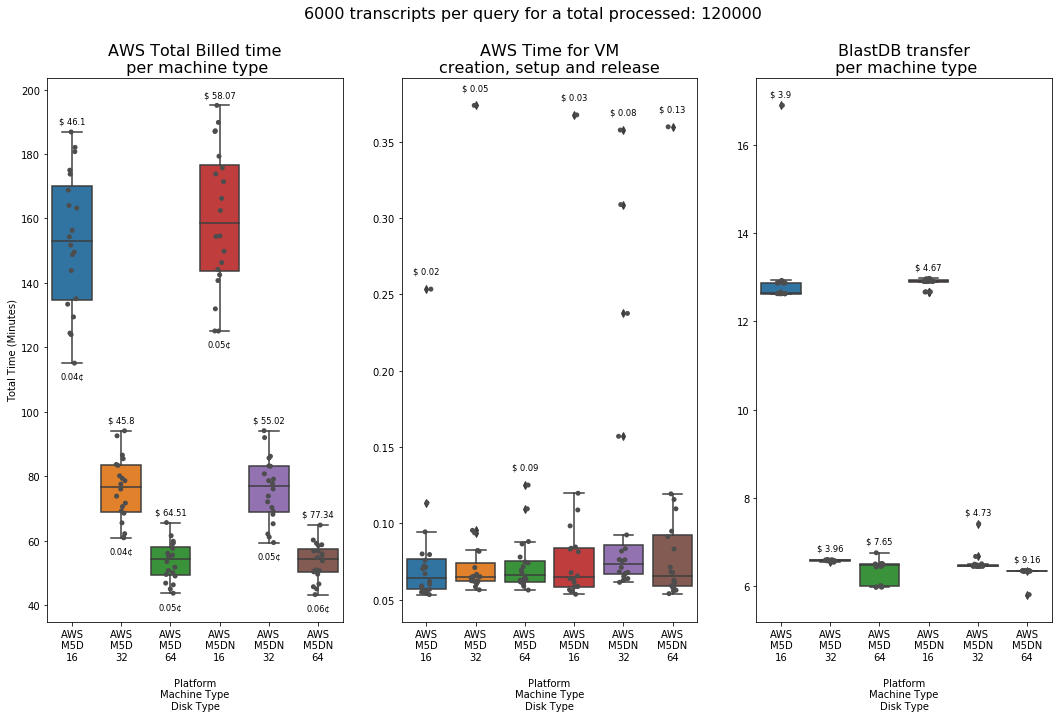

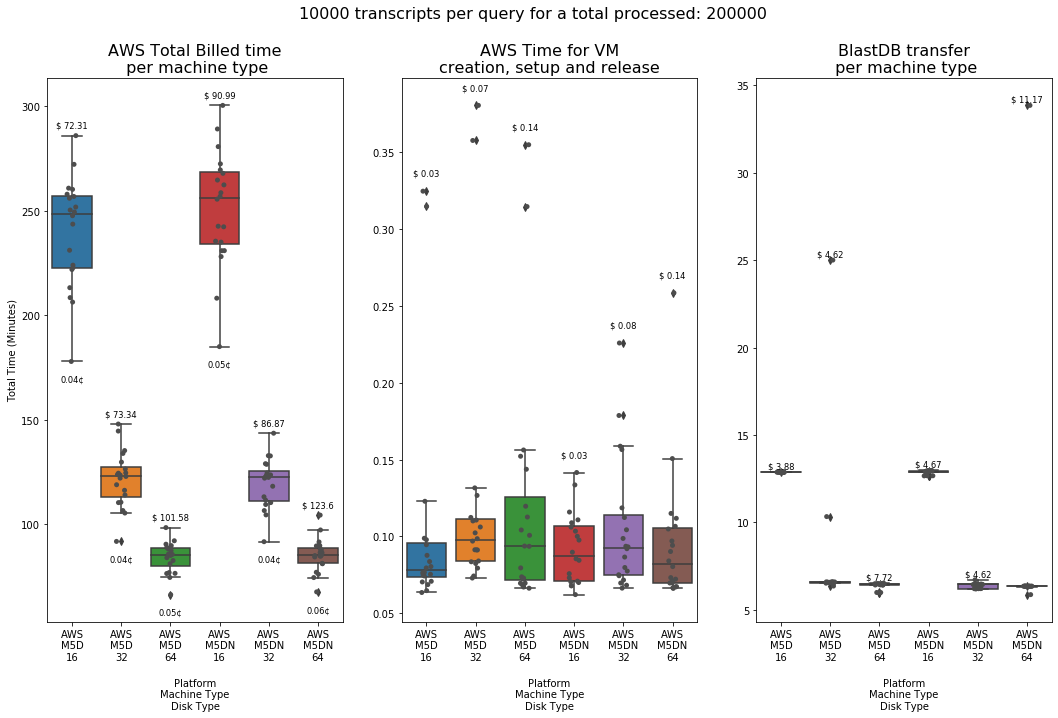

In [324]:
for q in QUERY_SIZES:
    df_total = job_ids[q]['total']
    df_blast = job_ids[q]['blast']
    df_creation = job_ids[q]['creation']

    fig, axs = plt.subplots(figsize=(18,10), ncols=3)

    fig.suptitle(locale.format_string("%d", int(q), grouping=True)
                         + ' transcripts per query for a total processed: ' 
                         + locale.format_string("%d", int(q) * 20, grouping=True)
                 + '\n\n', fontsize=16)

    j=0

    top = []
    low = []
    billed = []
    cost = []
    for p in df_total['Platform'].unique():
        f = p.lower().split('\n')
        top.append(df_total[df_total['Platform'] == p]['Time'].max())
        low.append(df_total[df_total['Platform'] == p]['Time'].min())
        billed.append('$ {}'.format(round(df_total[df_total['Platform'] == p]['Time'].sum()/60 * PRICE[f[1]][int(f[2])], 2)))
        cost.append('{:.2f}¢'.format(df_total[df_total['Platform'] == p]['Time'].sum()/60 * PRICE[f[1]][int(f[2])] * 100/(int(q) * 20)))


    box_plot = sns.boxplot(x="Platform", y="Time", data=df_total, ax=axs[j])
    
    top_tick = 1.6
    low_tick = 2.6
    if q == 6000:
        top_tick += 1.0
        low_tick += 2.4
    elif q == 10000:
        top_tick += 2.2
        low_tick += 7.2

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,top[xtick] + top_tick,billed[xtick], 
                horizontalalignment='center',size='small',weight='normal')

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,low[xtick] - low_tick,cost[xtick], 
                horizontalalignment='center',size='small',weight='normal')

    sns.stripplot(x="Platform", y="Time", data=df_total, jitter=True, color=".3", ax=axs[j])
    axs[j].set_ylabel("Total Time (Minutes)")
    axs[j].set_xlabel("\nPlatform\nMachine Type\nDisk Type")
    axs[j].set_title("AWS Total Billed time\n per machine type", fontsize=16)

    j = 1

    top = []
    billed = []
    for p in df_creation['Platform'].unique():
        f = p.lower().split('\n')
        top.append(df_creation[df_creation['Platform'] == p]['Time'].max())
        billed.append('$ {}'.format(round(df_creation[df_creation['Platform'] == p]['Time'].sum()/60 * PRICE[f[1]][int(f[2])], 2)))
        
    box_plot = sns.boxplot(x="Platform", y="Time", data=df_creation, ax=axs[j])

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,top[xtick] + 0.01,billed[xtick], 
                horizontalalignment='center',size='small',weight='normal')

    sns.stripplot(x="Platform", y="Time", data=df_creation, jitter=True, color=".3", ax=axs[j])
    axs[j].set_ylabel("")
    axs[j].set_xlabel("\nPlatform\nMachine Type\nDisk Type")
    axs[j].set_title("AWS Time for VM\ncreation, setup and release", fontsize=16)

    j = 2

    top = []
    billed = []
    for p in df_blast['Platform'].unique():
        f = p.lower().split('\n')
        top.append(df_blast[df_blast['Platform'] == p]['Time'].max())
        billed.append('$ {}'.format(round(df_blast[df_blast['Platform'] == p]['Time'].sum()/60 * PRICE[f[1]][int(f[2])], 2)))
        
    box_plot = sns.boxplot(x="Platform", y="Time", data=df_blast, ax=axs[j])

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,top[xtick] + 0.2,billed[xtick], 
                horizontalalignment='center',size='small',weight='normal')

    sns.stripplot(x="Platform", y="Time", data=df_blast, jitter=True, color=".3", ax=axs[j])
    axs[j].set_ylabel("")
    axs[j].set_xlabel("\nPlatform\nMachine Type\nDisk Type")
    axs[j].set_title("BlastDB transfer\n per machine type", fontsize=16)


In [325]:
for q in QUERY_SIZES:
    q_dir = os.path.join(result_dir, str(q))
    for m in MACHINE_TYPES:
        for c in CPUs:
            instace_dir = os.path.join(q_dir, m, str(c['CPUs']))
            os.chdir(instace_dir)
            files = [ f for ds, dr, files in os.walk('./') for f in files if f.endswith('_job.json.gz') ]
            for f in files:
                job_id = f.replace('_job.json.gz','')
                if os.path.exists('{}_job.json.gz'.format(job_id)):                        
                        with gzip.GzipFile('{}_job.json.gz'.format(job_id), 'r') as fin:  
                            job = json.loads(fin.read().decode('utf-8'))
                        job_name = job['jobs'][0]['jobName']
                        if job['jobs'][0]['jobId'] != job_ids[q][m][c['CPUs']][job_name]['jobId']:
                            print('{} {}_{} {}'.format(q, m, str(c['CPUs']), job_id))
                            os.remove('{}_job.json.gz'.format(job_id))
                            os.remove('{}_log.json.gz'.format(job_id))